In [8]:
"""
Created on Tue Jul 5 16:00:40 2022

@author: Hubeyb Gurdogan, Reyhaneh Mohammadi
"""

#!pip install --upgrade scipy networkx
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import random as rand
from scipy.stats import norm
import numpy as np
from numpy.random import RandomState as srng
import cvxopt as opt
from cvxopt import matrix, spmatrix, sparse
from cvxopt.solvers import qp, options
from cvxopt import blas
opt.solvers.options['show_progress'] = False

In [9]:
def buss_type_gen(fmrng, layer_id):
  """
  This function assigns a business type to each node based on its layer_id. The idea is that the main node be a heavy industrial type and as we get closer to the leaves the
  number of heavy industrial decreases.

  INPUT:
    layer_id: INT
    The layer that the node is located in
  OUTPUT
    INT
    An integer in {0,1,2,3} which shows the business type
  """
  # Heavy_industrial = 0
  # Light_industrial = 1
  # Metals/Minerals Processing = 2
  # IND5(High Technology) = 3
  if layer_id == 0:
    return 0
  else:
    if fmrng.uniform(0,1) < 1/(layer_id+4):
      return 0
    else:
      return fmrng.randint(1,4)

In [10]:
def recipeGraph(fmrng,allowed_out_degree, p,*level_sizes):
    
    """
    This function creates a directed,leveled, product dependency graph where each node is a critical product in the process and edges represent the dependency. 
    The created graph will have a single roof node that represents the final product. The graph is seperated into layers/levels where only
    the adjacent layers are permitted to form links. Each node in the graph will have a prod_id and the layer_id.
     
    level_sizes : A vector of d entries that specifies the number of nodes at each level. The entry level_sizes[0] is forced to be 1. 
    Note that the level sizes given as an input to generate a product dependency graph but the given level sizes are not 
    guranteed at the output as the nodes without an outgoing edge will be dropped.  
    Since we need adjacency list for recursion function we create and get it from this function as an output
    
    allowed_out_degree : Allowed max out degree for each level of the network.
    
    p : A real number in [0,1] that represents the probability of level i nodes to match with level i+1 nodes. 
        
    Outputs:
        G: The dependency graph of products
        adj_list (Dictionary/ keys: products, Values: list of all nodes that has a link to the key)
        This dictionary for each node in the graph keeps all nodes that has a link to it
        link_list (Dictionary/ keys: products, Values: list of all nodes that the key has a link to them)
        This dictionary for each node in the graph keeps all nodes that it has a link to them
    """
    
    extents = nx.utils.pairwise(itertools.accumulate((0,) + level_sizes))
    layers = [set(range(start, end)) for start, end in extents]
    G = nx.DiGraph()
    
    for (i, layer) in enumerate(layers):
        G.add_nodes_from(layer, layer_id=i)
        
    for node in G.nodes():
      G.nodes[node]['buss_type_id'] =  buss_type_gen(fmrng, G.nodes[node]['layer_id'])

    adj_list = {i:[] for i in G.nodes()} 
    link_list = {i:[] for i in G.nodes()} 
    G.add_edges_from([(u,v) for u in range(1,level_sizes[1]) for v in range(0,1)])
    

    count = 1
    adj_list[0] = [i for i in range(1,level_sizes[1])]   
    for i in range(1,level_sizes[1]):
      link_list[i] = [0]  
    
    for layer1, layer2 in nx.utils.pairwise(layers):
               
        """
       The nodes that has no incoming nodes are interpreted as the nodes that has no 
       critical supplier at the down stream of the production chain. Note that this includes the nodes that correspond to the 
       raw material suppliers. 
      
       If you want to choose the option that each node has a critical supplier, reveal the line below:
      
       #G.add_edges_from([(u,v) for v in layer1 for u in rand.sample(layer2,2)])
       
        """
        if layer1 != {0}:
          print('layers', layer1, layer2)  
          for v in layer1:
            for u in layer2:
              if fmrng.uniform(0,1)< p and G.out_degree(u)< allowed_out_degree[count]:
                G.add_edge(u,v)
                print('edge ',u, v)
                adj_list[v].append(u)
                link_list[u].append(v)
      
        """
      
        The below chunk of code is to remove the nodes that has no edges to the upper layer. Each critical node by assumption 
        should have a path to the final end product. 
    
        """
        temp = [u for u in layer2 if G.out_degree(u)==0]
       
        for u in temp:
            layer2.remove(u)
             
        G.remove_nodes_from(temp)
        count = count+1
    
    for u in G.nodes():
        G.nodes[u]['prod_id'] = u
    print('link ', link_list )
    return G, adj_list, link_list

In [12]:
def networkGraph(fmrng,G,max_prodbyprod_allowed, num_zones, p, link_lst):
    
    """
    This function will create the FDSN skeleton along with the consignment weights. It takes the product dependency graph as an input and than
    constructs the network by putting in possibly multiple nodes producing each product. The edges this time will cary weights where every incoming 
    weight for the same product will sum to 1 at each plant. As an example if producer of product "b" requires "a" and it is sourced 
    by two suppliers where %40 is from one and %60 from the other one, than the weights are 0.4 and 0.6 which is adding up to 1. Furthermore,
    we require each node to cary a zone id and its geocode in an artficial 2d zone of [0,1]x[0,1]. This will be used to create
    a correlation matrix when modeling the impact distribution. This can be dropped and a random covariance structure can be 
    drawn too.
    
    Since we need the number of copies for each node in the recursion phase we get them from this function as an output

    G: Product dependency graph.
     
    max_prodbyprod_allowed: A vector of d entries where its max_prodbyprod_allowed[i]  specifies the max number of producers allowed for each product that 
    appears at level i. We require this to be determined by an independent uniform draw from {1,2,..,m_i} for each product at level i. 
    
    num_zones: The number of zones. 
    
    
    Outputs: 
     G2: Graph
     node_copy: The number of plants producing each product
    """
        
    ######################################################################
    ### Phase 1: Adding in producers for each product at each level ######
    ######################################################################
    
    num_of_layers = len(max_prodbyprod_allowed)
    #print(num_of_layers)
    G2 = nx.DiGraph()
    node_copy = {}
    B_v = {} 
    for u in G.nodes():
        
        G2.add_node(u,layer_id=G.nodes[u]['layer_id'], prod_id = G.nodes[u]['prod_id'],buss_type_id = G.nodes[u]['buss_type_id'])
        num_copies = fmrng.randint(1,max_prodbyprod_allowed[G.nodes[u]['layer_id']]) # decides the number of copies for the product according to max number of copies allowed at its level
        node_copy[u] = num_copies
        
        
        for i in range(num_copies):
            label = u+0.1*i
            G2.add_node(label, layer_id=G.nodes[u]['layer_id'], prod_id = u ,buss_type_id = buss_type_gen(fmrng,G.nodes[u]['layer_id']))
            
    ######################################################################################
    ### Phase 2: Adding in links and weights guided by the product dependency graph ######
    ######################################################################################
    ### Note that there is a lower bound for the weight which is 0.08. If there are a lot of nodes in the graph it should be decreased
   
    for u in G.nodes():
      if u != 0:
        length = 0
        for v in link_lst[u]:
          for i in range(node_copy[u]):
            for j in range(node_copy[v]):
              length += 1
        weight_temp_normal = [0 for _ in range(length)]
        while any(item < 0.08 for item in weight_temp_normal):
          weight_temp = fmrng.uniform(0,1,length)
          weight_temp_normal = np.round(weight_temp/np.sum(weight_temp),2)
        ii = 0
        for v in link_lst[u]:
          for i in range(node_copy[u]):
            uu = u+0.1*i
            for j in range(node_copy[v]): 
              vv = v+0.1*j 
              G2.add_edge(uu, vv, con_weight = weight_temp_normal[ii])
              print(uu, vv, 'weight ', G2.edges[uu,vv]['con_weight'])
              if uu not in B_v.keys():
                B_v[uu]= [vv]
              else:
                B_v[uu].append(vv)           
              ii += 1

    return G2, node_copy, B_v
    

In [13]:
# def production_calc_i_g(Graph, node_cop_num, Recipe_graph_adj_lst): 
def production_calc_i_g(Graph, node_cop_num, Recipe_graph_adj_lst, affected_node):     
    """
    This function recursively calculates the production value for each node until it gets to the root node. Since the nodes in 
    the later layers are labeled with larger numbers we start updating from largest number to smallest which is 0, our root node.
    We added an attribute of production_val to each node. To make the compution faster we needed to know for each product how many 
    plants are making it and also the recipe graph adjacency lists. We give them as input to the function. When functionality of a 
    node is increasing to 1 only the production rate of the upper layer nodes in the supply chain would change and the rest
    remains unaffected. Hence we start the recursion from that specific node.
    
    We initialize the nodes production_val with their functionality and then update it
    
    
    Inputs: 
      Graph: Network graph
      node_cop_num (List of integers)
          This specifies that how many plants are producing each product
      
      Recipe_graph_adj_lst (Dictionary/ keys: products, values: list of all nodes that has a link to the key)
          This dictionary for each node in the graph keeps all nodes that has a link to it
      
      Affected_node (int)
          The node that its functionality is going up from 0 to 1. We start the recursion from that node because the 
          functionality of lower level nodes in supply chain would be unaffected
    
    Output:
       Graph: 
           The production values of each node (Which is an attribute of the graph) updates through the
           function and the new graph would be returned
           
       node_0_production_rate: Float
           The production rate of node 0
       
    
    """
    
    V = list(Graph.nodes())
    V = [i for i in V if i <= affected_node]
    V.reverse()
    for v in V:
        Graph.nodes[v]['production_val'] = Graph.nodes[v]['functionality']
        connected_nodes_to_v = Recipe_graph_adj_lst[int(v)]
        a = []
        for u in connected_nodes_to_v:
            temp_nom = 0
            temp_denom = 0
            for i in range(node_cop_num[u]):
                u1 = u + 0.1*i
                temp_nom += Graph.nodes[u1]['production_val']*Graph.edges[u1,v]['con_weight']
                temp_denom += Graph.edges[u1,v]['con_weight']
            a.append(temp_nom/temp_denom)
        if a != []:
            Graph.nodes[v]['production_val'] = min(Graph.nodes[v]['functionality'],min(a))
    node_0_production_rate = Graph.nodes[0]['production_val'] 
    return Graph, node_0_production_rate

In [14]:
def min_production_val_calc(Graph, B_v, node_cop_num):
    
    """
    This function backpropagates the production level to calculate the production level of each node which would be 
    enough to have the final production rate for node 0. They are the minimum production rates of each node that
    still provides the same final production rate for node 0 as if we do not do backpropagation.

    Inputs: 
      Graph: Network graph
      node_cop_num (List of integers)
          This specifies that how many plants are producing each product
      
      B_v (Dictionary/ keys: nodes of Graph, values: list of all nodes that the key is linked to them)
          This dictionary for each node in the graph keeps all nodes that the node has a link to them
      
    
    Output:
       Graph: 
           The min production values of each node (Which is an attribute of the graph) updates through the
           function and the new graph would be returned. 
           Matrixes A, b, h, G, Q and r are defined to solve the optimization problem
           z is the solution to the optimization problm 
           nom and denom are the nominator and denominator in formula of P (eq. 8 in the paper)
    """
    VV = list(Graph.nodes())
    for j in Graph.nodes():
        Graph.nodes[j]['min_production_val'] = 0
    Graph.nodes[0]['min_production_val'] = Graph.nodes[0]['production_val']
    for vv in VV:
        if vv != 0:
            if Graph.nodes[0]['min_production_val'] == 0:
                Graph.nodes[vv]['min_production_val'] = 0
            else:
                connected_nodes_from_vv = B_v[vv]
                nom = 0
                denom = 0       
                for uu in connected_nodes_from_vv:
                    denom += Graph.get_edge_data(vv, uu)['con_weight']
                    b = matrix(Graph.nodes[uu]['min_production_val'])
                    rr = node_cop_num[int(vv)]
                    bb_h = np.zeros(rr)
                    teta = np.array([])
                    for i in range(rr):
                        nd = int(vv)+0.1*i
                        bb_h = np.append(bb_h, Graph.nodes[nd]['production_val'])
                        teta = np.append(teta, Graph.get_edge_data(nd, uu)['con_weight'])
                
                    teta = teta/np.sum(teta)  
                    A = matrix(teta).T
                    h = matrix(bb_h)
                    G = matrix(np.concatenate((-np.eye(rr),np.eye(rr)),axis=0))
                    Q = matrix(np.eye(rr))
                    r = matrix(-2*np.ones(rr))
                
                
                    z = qp(Q, -r, G, h, A, b)['x'] 
                    #Get the index that we need to take from the solution
                    idx = round((vv-int(vv))/0.1)
                    D = z[idx]
                    nom += Graph.get_edge_data(vv, uu)['con_weight']*D
            
                Graph.nodes[vv]['min_production_val'] = nom/denom
    return Graph

In [15]:
def damage_state_interval(theta):
  """
  This function generates the damage state interval based on the equation P(X>s|theta)=phi((1/btea_s)*ln(theta/theta_s))
  for each damage state we give the theta_s to this function and then find the interval. The goal is to generate random uniform number and assign damage states of 
  NONE, SLIGHT, MODERATE, EXTENSIVE and COMPLETE based on PGA (theta) to each node in the Monte Carlo Simulation. 

  INPUT: FLOAT
    theta is PGA sensed in a node

  OUTPUT: LIST
    This list contains 5 numbers which each consecutive pair shows the interval for each damage state. e.g. if a random number is less that first value in the list it 
    would be translated to a damage state of NONE. If it is between first and second value in the list it would be translated to a damage state of SLIGHT

  """
  #none = 0
  #slight = 1
  #moderate = 2
  #extensice = 3
  #complete = 4

  damage_state_interval = {}

  beta_s = 0.64
  theta_s_slight = 0.20
  theta_s_mod = 0.26
  theta_s_ext = 0.46
  theta_s_comp = 0.84

  slight_cum_dis = norm.cdf((np.log(theta/theta_s_slight))/beta_s)
  mod_cum_dis = norm.cdf((np.log(theta/theta_s_mod))/beta_s)
  ext_cum_dis = norm.cdf((np.log(theta/theta_s_ext))/beta_s)
  comp_cum_dis = norm.cdf((np.log(theta/theta_s_comp))/beta_s)

  damage_state_interval[0] = 1-slight_cum_dis
  damage_state_interval[1] = 1-mod_cum_dis
  damage_state_interval[2] = 1-ext_cum_dis
  damage_state_interval[3] = 1-comp_cum_dis
  damage_state_interval[4] = 1

  return damage_state_interval

layers {1, 2, 3} {5, 6, 7, 8, 9, 10, 11, 12}
edge  7 1
edge  9 1
edge  11 1
edge  11 2
edge  5 3
edge  10 3
edge  11 3
layers {5, 7, 9, 10, 11} {13, 14, 15, 16, 17, 18, 19, 20, 21}
edge  21 5
edge  14 7
edge  15 7
edge  17 7
edge  14 9
edge  19 9
edge  20 10
edge  13 11
edge  14 11
link  {0: [], 1: [0], 2: [0], 3: [0], 4: [], 5: [3], 6: [], 7: [1], 8: [], 9: [1], 10: [3], 11: [1, 2, 3], 12: [], 13: [11], 14: [7, 9, 11], 15: [7], 16: [], 17: [7], 18: [], 19: [9], 20: [10], 21: [5]}


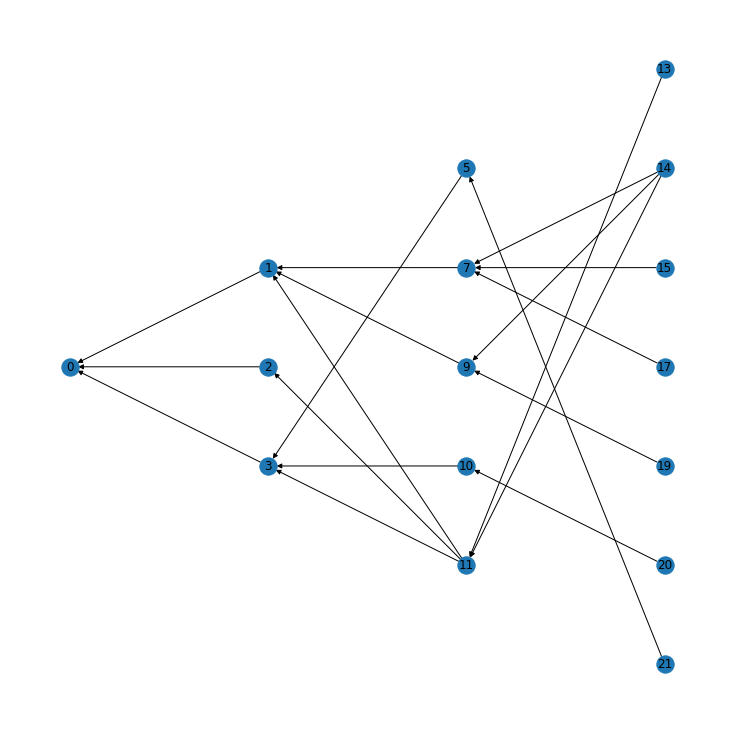

1.0 0.0 weight  1.0
2.0 0.0 weight  1.0
3.0 0.0 weight  1.0
5.0 3.0 weight  0.24
5.1 3.0 weight  0.37
5.2 3.0 weight  0.38
7.0 1.0 weight  0.88
7.1 1.0 weight  0.12
9.0 1.0 weight  0.58
9.1 1.0 weight  0.21
9.2 1.0 weight  0.2
10.0 3.0 weight  1.0
11.0 1.0 weight  0.13
11.1 1.0 weight  0.21
11.0 2.0 weight  0.11
11.1 2.0 weight  0.22
11.0 3.0 weight  0.08
11.1 3.0 weight  0.25
13.0 11.0 weight  0.22
13.0 11.1 weight  0.08
13.1 11.0 weight  0.22
13.1 11.1 weight  0.18
13.2 11.0 weight  0.21
13.2 11.1 weight  0.09
14.0 7.0 weight  0.08
14.0 7.1 weight  0.21
14.0 9.0 weight  0.09
14.0 9.1 weight  0.11
14.0 9.2 weight  0.14
14.0 11.0 weight  0.21
14.0 11.1 weight  0.17
15.0 7.0 weight  0.76
15.0 7.1 weight  0.24
17.0 7.0 weight  0.55
17.0 7.1 weight  0.45
19.0 9.0 weight  0.14
19.0 9.1 weight  0.08
19.0 9.2 weight  0.09
19.1 9.0 weight  0.12
19.1 9.1 weight  0.14
19.1 9.2 weight  0.1
19.2 9.0 weight  0.11
19.2 9.1 weight  0.14
19.2 9.2 weight  0.09
20.0 10.0 weight  1.0
21.0 5.0 weight  0.

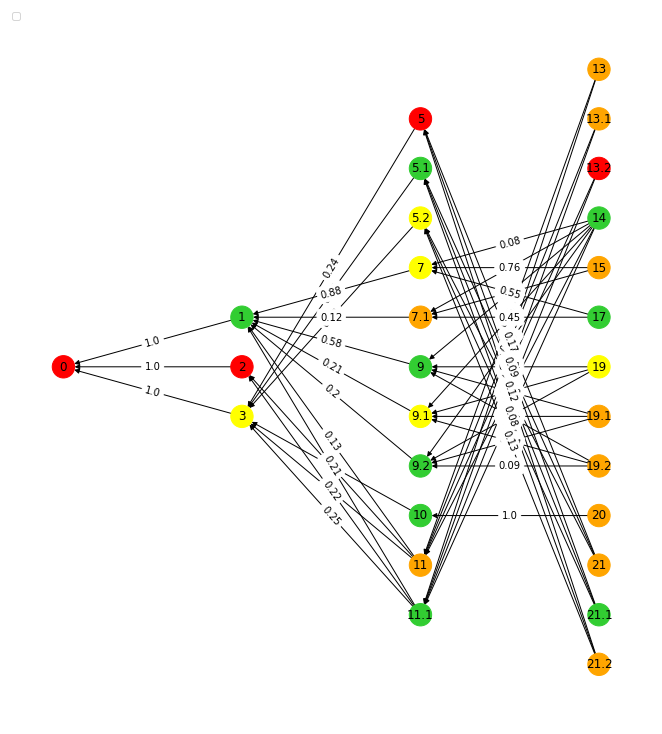

{1: 0.003, 2: 0.154, 10: 0.152, 14: 0.041}
Time 0 to 72 :
node 0 , min production val: 0.00
node 1 , min production val: 0.00
node 2 , min production val: 0.00
node 3 , min production val: 0.00
node 5 , min production val: 0.00
node 5.1 , min production val: 0.00
node 5.2 , min production val: 0.00
node 7 , min production val: 0.00
node 7.1 , min production val: 0.00
node 9 , min production val: 0.00
node 9.1 , min production val: 0.00
node 9.2 , min production val: 0.00
node 10 , min production val: 0.00
node 11 , min production val: 0.00
node 11.1 , min production val: 0.00
node 13 , min production val: 0.00
node 13.1 , min production val: 0.00
node 13.2 , min production val: 0.00
node 14 , min production val: 0.00
node 15 , min production val: 0.00
node 17 , min production val: 0.00
node 19 , min production val: 0.00
node 19.1 , min production val: 0.00
node 19.2 , min production val: 0.00
node 20 , min production val: 0.00
node 21 , min production val: 0.00
node 21.1 , min producti

In [20]:
if __name__ == "__main__":    
    
    seed = 48
    fmrng = srng(seed)
    
    #level_sizes = [1, 4, 6]
    level_sizes = [1, 4, 8, 9]
    #level_sizes = [1, 10, 20, 30, 40, 50 ,60, 70, 80, 90, 100]
    color_1 = [
            "red",
            "limegreen",
            "orange",
            "yellow"
            ]
    color_2 = [
            "limegreen",
            "red",
            "limegreen",
            "limegreen"
            ]
    #allowed_out_degree = [0, 3, 3]
    allowed_out_degree = [0, 3, 3, 3]
    #allowed_out_degree = [0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
    #max_prodbyprod_allowed = [2, 3, 3]
    max_prodbyprod_allowed = [2, 3, 4, 4]
    #max_prodbyprod_allowed = [2, 4, 4, 6, 6, 8, 8, 9, 9, 9, 9]
    num_buss_types = 4
    
    p = 0.2
    G, adj_lst, link_lst= recipeGraph(fmrng,allowed_out_degree, p, *level_sizes)
    color = [color_2[data["layer_id"]] for v, data in G.nodes(data=True)]
    pos = nx.multipartite_layout(G, subset_key="layer_id")


    plt.figure(3,figsize=(10,10)) 
    nx.draw(G, pos, with_labels = True)
    plt.show()
        
    """
    The below chunk of code is to test the networkGraph function

    """

    G2, num_copy, B_v = networkGraph(fmrng, G, max_prodbyprod_allowed, num_buss_types, p, link_lst)       
    color = [color_1[data["buss_type_id"]] for v, data in G2.nodes(data=True)]
    pos = nx.multipartite_layout(G2, subset_key="layer_id")


    plt.figure(3,figsize=(9,10)) 
    nx.draw(G2, pos, node_color=color, node_size=500 ,with_labels = True)
    labels = nx.get_edge_attributes(G2,'con_weight')
    nx.draw_networkx_edge_labels(G2,pos,edge_labels=labels)
    plt.legend(loc="upper left")
    plt.show()    
    """
      This chunk of code gives the list of affected nodes and assigns the value of PGA of event to each node to decide on the node (plant) damage state
      If a node is not in the affected list its functionality is 1 and does not have any down time
    """
    affected_nodes = [1, 2, 10, 14]  # This list saves the nodes that are affected by a hazardous event
    PGA_on_node = {}
    for i in affected_nodes:
      PGA_on_node[i] = np.round(3*np.random.rand()/9.8,3)
    #PGA_on_node = {2.1:0.253, 5.1:0.299, 9.1:0.287 , 13:0.161 , 16.2:0.161 , 18.1:0.115}
    print(PGA_on_node)
    for vv in G2.nodes():
      if vv not in affected_nodes:
        G2.nodes[vv]['functionality'] = 1
    

    fin_loss_list = []
    fin_loss_percentage_list = []
    window_time_list = []
    for s in range(10):
      nodes_dt = {}    # A dictionary for saving downtime and corresponding nodes. downtime is the key and node is the value
      np.random.seed(s)
        

      #hazus_rcvry_time = [[10, 90, 240, 360],[10 90 240 360],[10 90 240 360],[20 135 360 540]]
      #hazus_mltpr = [[0.5 1.0 1.0 1.0],[0.1 0.2 0.3 0.4],[0.2 0.2 0.3 0.4],[0.2 0.2 0.3 0.4]]
      #ORDER_OF_ROWS: Heavy, Light, Metal, HighTech
      #ORDER_OF_COLS: Slight, Moderate, Extensive, Complete
      hazus_dt_lst = [[5, 90, 240, 360],[1, 18, 72, 144],[2, 18, 72, 144],[4, 27, 108, 216]]

      """
      This chunk of code creates the damage ratio intervals for each node and then using a uniform random variable assigns the damage state to each one of the nodes that are affected by the event
      Then looks up the median of downtime (recovery time) in the hazus_dt_lst and assigns the corresponding down time to each node
      """

      for vv in affected_nodes:
        dmg_ratio_int = damage_state_interval(PGA_on_node[vv])
        rand_num = srng(s).uniform(0,1)
        if rand_num > dmg_ratio_int[0]:
          G2.nodes[vv]['functionality'] = 0 
          if rand_num < dmg_ratio_int[1]:
            vv_dmg_state = 1  # slight
          elif rand_num < dmg_ratio_int[2]:
            vv_dmg_state = 2 # moderate
          elif rand_num < dmg_ratio_int[3]:
            vv_dmg_state = 3 # extensive
          else:
            vv_dmg_state = 4 # complete
        
          vv_business_type = G2.nodes[vv]['buss_type_id']

          if hazus_dt_lst[vv_business_type][vv_dmg_state-1] not in nodes_dt.keys():
            nodes_dt[hazus_dt_lst[vv_business_type][vv_dmg_state-1]] = [vv]
          else:
            nodes_dt[hazus_dt_lst[vv_business_type][vv_dmg_state-1]].append(vv)
        else:
            G2.nodes[vv]['functionality'] = 1
    
    
      # Sort the downtimes to change the functionality after passing the downtime for each node and use it in the recursion
      d_time_ordered = dict(sorted(nodes_dt.items(), key=lambda item: item[0]))
      d_time_ordered_lst = list(d_time_ordered.keys())
#      print("-----------------------")
#      print('{downtime: node}:', d_time_ordered)
   
      """
      This chunk of code calculates the production of root node between the downtimes and after passing each downtime 
      makes the functionality of corresponding node equal to 1. Moreover we calculate the min production val 
      for each node that leads to same production val for root node.
    
      fin_loss_list saves the losses between two downtimes in a list.
      time starts from 0 and then increases in steps based on ordered down time of all shocked nodes
      g_production is the production of root node in a time interval.
      affected_node is the node that its functionality goes up from 0 to 1 because its downtime is ended
      """
      nodes_min_production_rate = {}
    
      if d_time_ordered != {}:
        Window_Time = max(d_time_ordered.keys())
        time = 0     
        g_production = 0
        affected_node = max(G2.nodes())
        for i in range(len(d_time_ordered)):
            time_len = d_time_ordered_lst[i] - time
            G2, last_node_production = production_calc_i_g(G2, num_copy, adj_lst, affected_node)
            
            print('Time',time, 'to', d_time_ordered_lst[i],':')
            g_production += time_len * last_node_production
            G2 = min_production_val_calc(G2, B_v, num_copy)
            for nd in G2.nodes():
                print('node', nd, ', min production val:', format(G2.nodes[nd]['min_production_val'], ".2f"))
                if nd not in nodes_min_production_rate.keys():
                    nodes_min_production_rate[nd] = [[time],[G2.nodes[nd]['min_production_val']]]
                else:
                    if abs(G2.nodes[nd]['min_production_val'] - nodes_min_production_rate[nd][1][-1]) >0.0001:
                        nodes_min_production_rate[nd][0].append(time)
                        nodes_min_production_rate[nd][1].append(G2.nodes[nd]['min_production_val'])

                    
            time = d_time_ordered_lst[i]
            for item in d_time_ordered[d_time_ordered_lst[i]]:
              G2.nodes[item]['functionality'] = 1
            affected_node = max(d_time_ordered[d_time_ordered_lst[i]])
        g_production_loss = Window_Time - g_production
        print('Production loss:',g_production_loss)
        
        """
        This chunk of code is only for print of min production rate of nodes afterback propagation
        """
        print('NODES MIN PRODUCTION THROUGH TIME')
        for i in nodes_min_production_rate.keys():
            ls = []
            if len(nodes_min_production_rate[i]) == 1:
                ls.append('From time '+str(nodes_min_production_rate[i][0][0])+' to time '+str(max(d_time_ordered))+': min production rate='+str("{:.2f}".format(nodes_min_production_rate[i][1][0])))
            else:
                for j in range(len(nodes_min_production_rate[i][0])-1):
                    ls.append('From time '+str(nodes_min_production_rate[i][0][j])+' to time '+str(nodes_min_production_rate[i][0][j+1])+': min production rate='+str("{:.2f}".format(nodes_min_production_rate[i][1][j])))
                ls.append('From time '+str(nodes_min_production_rate[i][0][-1])+' to time '+str(max(d_time_ordered))+': min production rate='+str("{:.2f}".format(nodes_min_production_rate[i][1][-1])))
            
#            print('Node',i,ls)

        fin_loss_list.append(g_production_loss)
        fin_loss_percentage_list.append(g_production_loss/Window_Time)
        window_time_list.append(Window_Time)
      else:
        fin_loss_list.append(0)
        fin_loss_percentage_list.append(0)
        window_time_list.append(0)

#    print(fin_loss_list)
#    print(fin_loss_percentage_list)    
    Expected_loss = np.mean(fin_loss_list)
    Expected_perc_loss = np.mean(fin_loss_percentage_list) 
    avg_window = np.mean(window_time_list)
    loss_percentage = Expected_loss/avg_window 
    print(Expected_loss)
    print(Expected_perc_loss)
    print(avg_window)
    print(loss_percentage)

In [ ]:
nx.eigenvector_centrality(G2, max_iter=1000)

In [ ]:
nx.betweenness_centrality(G2)

{0: 0.0,
 1: 0.0,
 2: 0.03333333333333333,
 3: 0.016666666666666666,
 3.1: 0.016666666666666666,
 7: 0.0,
 7.1: 0.0,
 8: 0.0,
 8.1: 0.0,
 9: 0.0,
 10: 0.0}

In [ ]:
pr = nx.pagerank(G2, alpha=0.9)
sorted((v, f"{c:0.2f}") for v, c in pr.items())

[(0, '0.38'),
 (1, '0.04'),
 (2, '0.15'),
 (3, '0.09'),
 (3.1, '0.09'),
 (7, '0.04'),
 (7.1, '0.04'),
 (8, '0.04'),
 (8.1, '0.04'),
 (9, '0.04'),
 (10, '0.04')]

Calculating the effect of each node on root node production rate by putting that node functionality equal to 0 and other nodes functionalities equal to 1

In [ ]:
Graph = G2.copy()
node_importance = {}
V = list(Graph.nodes())
V.reverse()
for u in V:
    Graph.nodes[u]['functionality'] = 0
    Graph.nodes[u]['production_val'] = 0
    for v in V:
        if v != u:
            Graph.nodes[v]['functionality'] = 1
            Graph.nodes[v]['production_val'] = Graph.nodes[v]['functionality']
            connected_nodes_to_v = adj_lst[int(v)]
            a = []
            for uu in connected_nodes_to_v:
                temp = 0
                for i in range(num_copy[uu]):
                    u1 = uu + 0.1*i
                    temp += Graph.nodes[u1]['production_val']*Graph.edges[u1,v]['con_weight']
                a.append(temp)
            if a != []:
                Graph.nodes[v]['production_val'] = min(Graph.nodes[v]['functionality'],min(a))
    node_0_production_rate = Graph.nodes[0]['production_val'] 
    node_importance[u] = node_0_production_rate
print({k: v for k, v in sorted(node_importance.items(), key=lambda item: item[1])})

{10: 0.0, 9: 0, 2: 0, 1: 0, 0: 0, 7.1: 0.19, 3: 0.4, 8.1: 0.466, 8: 0.534, 3.1: 0.6, 7: 0.81}


In [ ]:
print(nx.__version__)

2.7.1


In [ ]:
print(scipy.__version__)

1.7.3


In [ ]:
!pip install --upgrade scipy

In [ ]:
print(scipy.__version__)

1.7.3


In [ ]:
pip install scipy==1.8.0

     |████████████████████████████████| 55.6 MB 8.0 MB/s eta 0:00:011
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.0
    Uninstalling scipy-1.9.0:
      Successfully uninstalled scipy-1.9.0
Note: you may need to restart the kernel to use updated packages.
